# Appendix

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from scipy.stats import shapiro
from scipy.stats import binned_statistic
from scipy.stats import chisquare

## 1. Function definitions

In this section the following functions are defined:

1. generate_random: this function is uses the linear congruential method to generate a sequence of pseudo-random numbers between 0 and 1.
2. calc_moments: This provides sample moments from the generated sequence of pseudo random numbers.
3. Sn: this function is the empirical distribution function of the random sequence generated by the previous function.
4. evaluate_pseudo_random: this function evaluates the Kolmogorov-Smirnov (KS) statistic to determine if $S_n$ follows a uniform distribution.

### 1.1 generate_random
We implement the generator $X_{n+1}$ = $7^5X_{n}$ mod $(2^{31} - 1)$. Here the user may specify the size of the sample they wish to generate. The algorithm is as follows:

1. Specify sample size $n$ and seed value $x_0$
2. Create an empty array of size $n$
3. From $i$ equals $1$ to $n$, calculate $X_{i+1}$ = $7^5X_{i}$ mod $(2^{31} - 1)$ and store the value in position $i$ of the array.
4. Divide each element of the array by $2^{31}-1$
5. Return the resulting array. It will contain the pseudo-random numbers desired.

In [2]:
def generate_random(n, seed = 1):
    '''This function generates pseudo-random numbers using the linear congruential method. As arguments it takes the desired sample size n and an optional seed.'''
    # Initialize an empty array with n elements.
    random_array = np.zeros(n)
    # Set the seed.
    random_array[0] = seed
    # Fill the array using the linear congruential method.
    for i in range(1,n):
        random_array[i] = random_array[i-1]*(7**5) % (2**31 - 1)
    # Divide each element by the modulus value to create pseudo-random numbers then return
    random_array = random_array / (2**31 - 1)
    return random_array

### 1.2 calc_moments
This function calculates all the sample moments corresponding to the random numbers generated from the previous function. Namely, the

1. Sample mean
2. Sample variance
3. Sample skewness
4. Sample kurtosis

In [3]:
def calc_moments(random_array):
    '''Calculate sample moments for the pseudo-random numbers. Return them as a tuple. '''
    # Sample mean
    xbar = random_array.mean()
    # Sample variance
    variance = random_array.var()
    # Biased sample standard deviation
    stddev = random_array.std()
    # Sample standard deviation (divided by n-1)
    samstd = random_array.std(ddof=1)
    # Sample skewness
    skew = ((random_array - xbar)**3).sum()/n/samstd**3
    # Sample kurtosis
    exkurt = (((random_array - xbar)/stddev)**4).sum()/n - 3 
    
    return (xbar, variance, stddev, skew, exkurt)

### 1.3 Sn
This function is the python implementation of the empirical distribution function $S_n$ defined by

\begin{split}
S_n(x) & = 0 \text{  for } x<x_{(1)}   \\
 & = \frac{r}{n} \text{  for } x_r \leq x < x_{r+1} \\
 & = 1 \text{  for } x_n \leq 1 \\
\end{split}

As arguments it takes both an ordered sample and element $x$.

In [4]:
def Sn(sample, x):
    ''' Sn is the sample distribution function for the random numbers generated using the linear
    congruential method. This function takes the sorted sample as an argument along with a particular x value.
    It then determines where x lies relative to the sorted sample values and returns the approximate cumulative uniform
    probability.'''
    # Hold onto value of n.
    n = len(sample)
    # Find the index r1 such that sample[r1-1] <= x < sample[r1].
    r1 = np.searchsorted(sample, x, side = 'right' )
    r0 = r1 - 1
    # Check conditions. If r1 = n, then return 1 (indexing starts at 0, so n isn't possible). 
    # Else if r0 = -1, then r1 = 0, so return 0.
    # Otherwise x is somewhere in the interior of the array, return r0/n.
    if r1 == n:
        return 1
    elif r0 == -1:
        return 0
    elif sample[ r0 ] <= x < sample[ r1 ]: 
        return r0 / n

### 1.4 evaluate_pseudo_random

This function performs all the heavy lifting. It is responsible for sorting the data array, evaluating the KS statistic, performing a $\chi^2$ goodness-of-fit (GOF) test, and providing some output. As arguments it takes the pseudo-random array and a boolean flag specifying whether to provide verbose output. The operation of the function is as follows:

1. Sort the provided array of pseudo-random numbers
1. Create an empty array to populate with calculated values of $S_n$
1. From $i$ equals $0$ to $n-1$, using the $ith$ value of the array of pseudo-random numbers calculate the $ith$ value of $S_n$. Append it to the array created in step 2.
1. Conduct Tests
 2. Kolmogorov-Smirnov 
    1. Calculate the element-wise differences between the values of $S_n$ and the CDF of the uniform distribution.
    2. Calculate the maximum value of the aforementioned differences.
    3. Determine that maximum is less than the cutoff $\frac{1.6276}{\sqrt{n}}$
 2. Goodness-of-Fit
    1. Bin sample observations using #(bins) = $floor(1.88n^{(2/5)}$) 
    2. Calculate expected bin counts according to uniform assumption
    3. Calculate statistic and p-value 
1. Return test results along with the array of $S_n$ values and the maximum likelihood estimate for the uniform distribution.

In [5]:
def evaluate_pseudo_random(random_array, output=True):
    '''This function evaluates whether an array of random numbers was generated from a uniform distribution using the 
    Kolmogorov-Smirnov statistic. Returns a boolean variable with value True if the random numbers satisfy the test along with
    the sample distribution function and ML estimator for uniform distribution.'''
    
    n = len(random_array)
    
    # KS Test
    # Make a sorted copy of the array.
    random_array_sorted = np.sort(random_array)
    # Create an array of values corresponding to Sn
    Sn_array = np.empty(0)
    for i in range(0,n):
        Sn_array = np.append( Sn_array, Sn(random_array_sorted, random_array[i]) )
    # Calculate the difference between Sn and F, where F is the density of the uniform (0,1) distribution.
    difference = abs(Sn_array - random_array)
    # Find the maximum difference
    D = max(difference)
    # Compare to the cut-off.
    KSpassfail = D < 1.6276/np.sqrt(n)
    
    # Chi-squared goodness of fit
    # Bin observations.
    obs = np.histogram(random_array, bins = int(np.floor( 1.88*n**(2/5) )))[0]
    # Calculate the expected bin counts under the uniform density hypothesis.
    expected = np.zeros(len(obs)).fill( int(n/len(obs)) )
    # Extract results
    (chisq , p_val) = chisquare(obs,expected)
    GOFpassfail = p_val - 0.05 < 0

    # If output is specified, provide answers in a pretty format.
    if output == True:
        print("Kolmogorov-Smirnov statistic: D = "+str(D))
        print("D < 1.6276/sqrt("+str(n)+")? " + str(KSpassfail))
        print("Chi-square GOF statistic: X2 = "+str(chisq))
        print("Reject null (uniform) hypothesis?  "+str(GOFpassfail))
    # Return a tuple containing 1) whether K-S test is satisfied, 2) the array Sn_array.
    return (KSpassfail, Sn_array, random_array_sorted[-1], GOFpassfail)

## 2. Application
In this section the functions above are used to evaluate the linear congruential method. In particular, we use the generator $X_{n+1}$ = $7^5X_{n}$ mod $(2^{31} - 1)$ and an initial sample size of $n = 1000$ points.


If the linear congruential random number generator does a satisfactory job generating uniform random variates, we expect that 1) the Kolmogorov-Smirnov test must result in a value $D = \sup_x |S_n(x) - F(x)| < \frac{1.6276}{\sqrt{n}}$, 2) the sample moments must be close to the theoretical moments, and 3) consecutive values of the sample must be uncorrelated.

### 2.1 Single application
The following is a single run of the functions implemented above along with initial diagnostics, including sample moments, autocorrelation plot, and plot of empirical and theoretical CDFs.

The operation of this block is as follows:

1. Specify $n$
2. Generate a sample of size $n$ of pseudo-random numbers using the linear congruential method and a random integer seed value.
3. Evaluate the Kolmogorov-Smirnov statistic and GOF statistic.
4. Calculate sample moments
5. Output the results of KS & GOF tests and the observed vs. expected moments.

In [6]:
# Specify sample size
n = 1000
# Set seed
np.random.seed(1)
# Generate array with random integer seed for the generator.
random_array = generate_random(n, np.random.randint(0,1000000))
result = evaluate_pseudo_random(random_array)
result2 = calc_moments(random_array)
print("Maximum Likelihood Estimator: " + str(result[2]))
print("Expected mean: 0.5 | Observed mean: " + str(result2[0]))
print("Expected variance: 0.08333 | Observed variance: " + str(result2[1]))
print("Expected skewness: 0 | Observed skewness: " + str(result2[3]))
print("Expected kurtosis: -1.2 | Observed kurtosis: " + str(result2[4]))

Kolmogorov-Smirnov statistic: D = 0.03887864760816029
D < 1.6276/sqrt(1000)? True
Chi-square GOF statistic: X2 = 28.282
Reject null (uniform) hypothesis?  False
Maximum Likelihood Estimator: 0.9997229827566645
Expected mean: 0.5 | Observed mean: 0.4848807121039745
Expected variance: 0.08333 | Observed variance: 0.07853131904261722
Expected skewness: 0 | Observed skewness: 0.05342503203593479
Expected kurtosis: -1.2 | Observed kurtosis: -1.1021384103991194


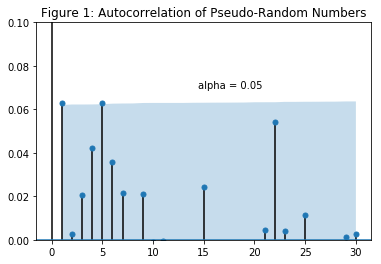

In [7]:
# ACF Plot
fig = tsaplots.plot_acf(random_array, lags = 30,title = 'Figure 1: Autocorrelation of Pseudo-Random Numbers')
fig.text(.5,.65,'alpha = 0.05')
# Adjust y axis limits -- autocorrelations are very small (this is good!)
ax = fig.gca()
ax.set_ylim([0,0.1])
plt.savefig('fig1.png', format = 'png')

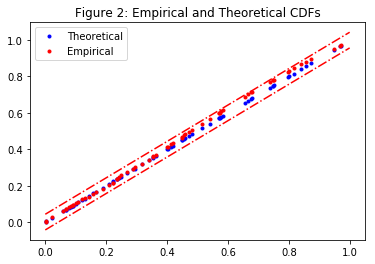

In [8]:
plots = plt.plot(random_array[1:n:15], random_array[1:n:15], 'b.', random_array[1:n:15], result[1][1:n:15], 'r.')
pt_est = [(j-0.5)/1000 for j in range(1, 1001)]
plt.plot( pt_est, (pt_est + 1.36/np.sqrt(n)), ls= '-.', lw = 1.5, color = 'red' )
plt.plot( pt_est, (pt_est - 1.36/np.sqrt(n)), ls= '-.', lw = 1.5, color = 'red')
plt.title("Figure 2: Empirical and Theoretical CDFs")
plt.legend(plots, ('Theoretical', 'Empirical', '95% Confidence Interval'))
plt.savefig('fig2.png', format = 'png')

### 2.2 Sampling (multiple applications)

Here we generate multiple sequences of length $1000$ of pseudo-random numbers and take a closer look at the moments of each. Particularly, the sampling distributions for each are plotted to assess the large sample behavior of the sample moments. For each sampling distribution the Shapiro-Wilk test is conducted to determine normality. Additionally, a bar chart of KS successes is plotted, a plot of the theoretical uniform and average empirical CDFs is given, and the the ECDF of individual samples of size 1000, 5000, 10000, and 20000 are compared to the theoretical uniform. 

The logic for this block is:

1. Initialize arrays that will hold the sample moments for each sample, MLES , as well as as one that will contain the values of the average ECDF calculated across samples.
2. From j = 0 to 4999, generate a sequence of 1000 pseudo-random numbers using the linear congruential method above with a random integer seed.
 1. Evaluate KS statistic and sample moments 
 2. Save sample distribution and sample moments
3. Use saved sample distribution values to calculate average ECDF.

In [9]:
# Initialize arrays to hold the sample moments and element-wise means for each run.

# The s array holds the outcome of the KS tests.
s = []
# Chi-square GOF outcomes
gofs = []
# MLEs contains MLEs
MLEs = []
# xbb contains sample means
xbb = []
# vb contains sample variances
vb = []
# skewb contains sample skewness
skewb = []
# exkurtb contains sample kurtosis.
exkurtb = []
# sample_dist_means
sample_dist_means = np.zeros(1000)

# Run the KS test for 5000 samples of pseudo-random numbers, each generated with a random integer seed.
# Then append all moments to their relevant arrays.
for j in range(0,5000):
    # Generate the pseudo-random numbers
    random_array = generate_random( n, np.random.randint(0,500000) )
    # Evaluate KS stat and moments
    result = evaluate_pseudo_random(random_array, output=False)
    result2 = calc_moments(random_array)
    sample_dist_means = sample_dist_means + np.sort(result[1])
    # Save successes, MLEs, and moments,
    s.append(result[0])
    gofs.append(result[3])
    MLEs.append(result[2])
    xbb.append(result2[0])
    vb.append(result2[1])
    skewb.append(result2[3])
    exkurtb.append(result2[4])
    
# Calculate element-wise means across all runs.
sample_dist_means = sample_dist_means/5000

#### 2.2.1 Test Results
Note: we know that if the empirical distribution is the result from a sample from the theoretical distribution $F$, then with probability $0.99$ the KS statistic will be less than $\frac{1.6276}{\sqrt{n}}$. Thus, for these multiple test runs we expect to see a success rate of at least $0.99$ if the pseudo-random number generator does a satisfactory job of generating numbers from a uniform distribution. That is, we want to see $0.99 < \frac{\#(true)}{\#(runs)}$

For the GOF test, the sample is assumed to be uniformly distributed under the null hypothesis. Thus, we expect to see a large number of failures if the samples generated are indeed from a uniform distribution. The $\chi^2$ GOF test is known to be fairly conservative, so if $0.95 < \frac{\#(false)}{\#(runs)}$, we should be fairly happy with the results

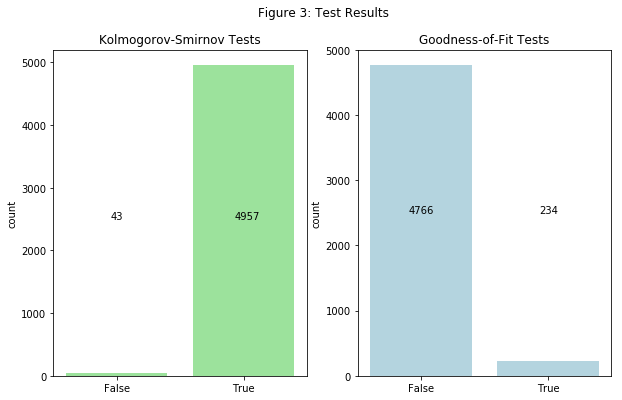

In [10]:
fig = plt.figure(figsize=(10,6))
fig.suptitle("Figure 3: Test Results")
# KS Plot
ax = fig.add_subplot(1, 2, 1)
sns.countplot(s, color = 'lightgreen', ax = ax)
ax.set_title("Kolmogorov-Smirnov Tests")
ax.text(0.93,2500, sum(s))
ax.text(-0.05,2500, 5000 - sum(s))
# GOF Plot
ax = fig.add_subplot(1, 2, 2)
sns.countplot(gofs, color = 'lightblue', ax = ax)
ax.set_title("Goodness-of-Fit Tests")
ax.text(0.93,2500, sum(gofs))
ax.text(-0.1,2500, 5000 - sum(gofs))
plt.savefig('fig3.png', format = 'png')

2.2.2 Distribution of Maximum Likelihood Estimators

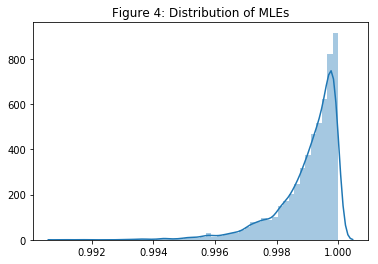

In [11]:
ax = sns.distplot(MLEs)
ax.set_title('Figure 4: Distribution of MLEs')
plt.savefig('fig4.png', format = 'png')

#### 2.2.3 Sampling Distributions of Moments

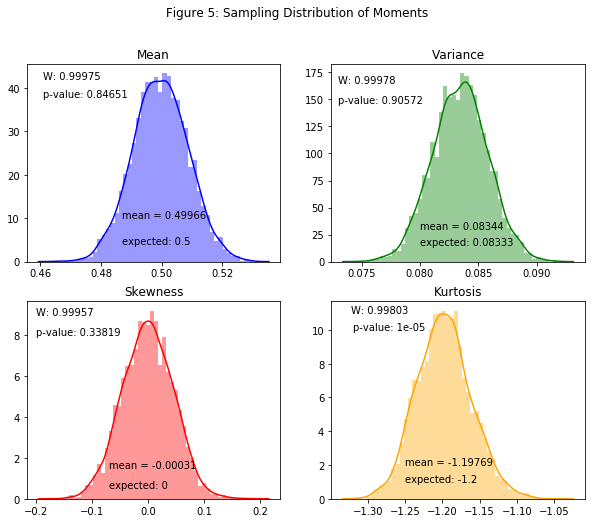

In [12]:
fig = plt.figure(figsize=(10,8))
fig.suptitle("Figure 5: Sampling Distribution of Moments")

# Mean
ax = fig.add_subplot(2, 2, 1)
sns.distplot(xbb,color='blue', ax = ax)
ax.set_title("Mean")
ax.text(0.487,10, "mean = " + str(round(np.mean(xbb), 5)))
ax.text(0.487,4,"expected: 0.5")
ax.text(0.461,42, "W: "+ str( round(shapiro(xbb)[0], 5)))
ax.text(0.461,38,"p-value: "+str( round(shapiro(xbb)[1], 5)))

# Variance
ax = fig.add_subplot(2, 2, 2)
sns.distplot(vb, color = 'green', ax = ax)
ax.set_title("Variance")
ax.text(0.08,30, "mean = " + str(round(np.mean(vb), 5)))
ax.text(0.08,15,"expected: 0.08333")
ax.text(0.073,165, "W: "+ str( round(shapiro(vb)[0],5)))
ax.text(0.073,147,"p-value: "+str( round(shapiro(vb)[1], 5)))

# Skewness
ax = fig.add_subplot(2, 2, 3)
sns.distplot(skewb, color = 'red', ax = ax)
ax.set_title("Skewness")
ax.text(-0.07,1.5, "mean = " + str(round(np.mean(skewb), 5)))
ax.text(-0.07,.5,"expected: 0")
ax.text(-0.2,9, "W: "+ str( round(shapiro(skewb)[0],5)))
ax.text(-0.2,8,"p-value: "+str( round(shapiro(skewb)[1],5)))

# Kurtosis
ax = fig.add_subplot(2, 2, 4)
ax = sns.distplot(exkurtb, color = 'orange', ax = ax)
ax.set_title("Kurtosis")
ax.text(-1.25,2, "mean = " + str(round(np.mean(exkurtb), 5)))
ax.text(-1.25,1,"expected: -1.2")
ax.text(-1.322,11, "W: "+ str(round(shapiro(exkurtb)[0],5)))
ax.text(-1.32,10,"p-value: "+str(round(shapiro(exkurtb)[1],5)))

plt.savefig('fig5.png', format = 'png')

#### 2.2.4 Large Sample Averaged Empirical CDF vs. Theoretical
Note: we expect that in the long run, the average empirical CDF converges to the theoretical uniform CDF. That is, given empirical CDFs resulting from numerous samples of size $n$, $S_n^{(1)}, S_n^{(2)}, \ldots, S_n^{(m)}$, we hope that $\sum_{i=1}^{m} \frac{S_n^{(i)}}{m} \to F$. In this case, we find $m = 5000$ sample distributions. 

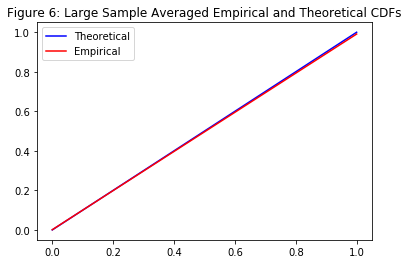

In [13]:
plots = plt.plot(np.linspace(0,1,20), np.linspace(0,1,20), 'b-', np.linspace(0,1, len(sample_dist_means[1:n:15])),  sample_dist_means[1:n:15], 'r-')
plt.title("Figure 6: Large Sample Averaged Empirical and Theoretical CDFs")
plt.legend(plots, ('Theoretical', 'Empirical'))
plt.savefig('fig6.png', format = 'png')

#### 2.2.5 Empirical CDFs for Varying Sample Sizes 
Here the plots of ECDFs for pseudo-random samples of size 1000, 5000, 10000, and 20000 are plotted against the theoretical CDF. We expect that there shouldn't be any significant departures from the theoretical CDF for larger samples.

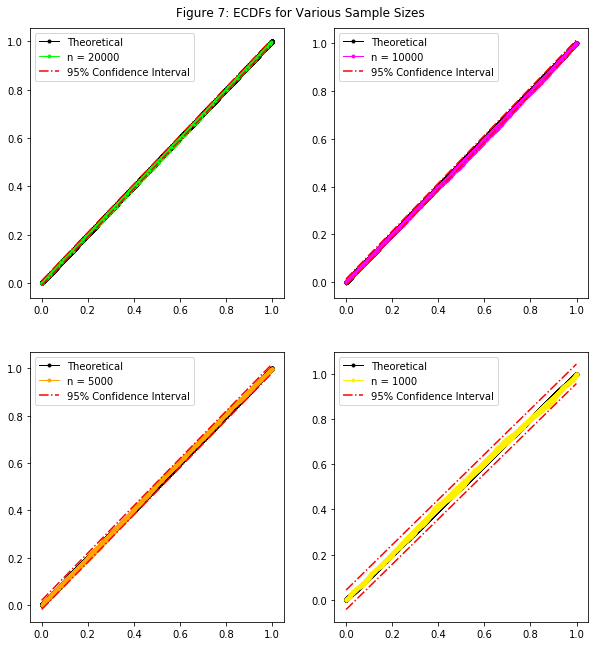

In [14]:
results = []
colors = ['#00FF00', '#FF00FF', '#FFA500', '#FFF000']
styles = ['.', '.' , '.', '.']
size = [20000, 10000, 5000, 1000]
step = [100, 10, 5, 1]
sample_name = ('n = 20000', 'n = 10000', 'n = 5000', 'n = 1000')

fig = plt.figure(figsize=(10,10))
fig.suptitle("Figure 7: ECDFs for Various Sample Sizes")
fig.subplots_adjust(top = .95)
for i in range(0,4):
    pt_est = [(j-0.5)/size[i] for j in range(1, size[i]+1)]
    random_array = generate_random(size[i], np.random.randint(0,500000) )
    results.append(evaluate_pseudo_random(random_array, output=False)[1] )
    ax = fig.add_subplot(2, 2, i+1)
    plt.plot(np.linspace(0,1,10000), np.linspace(0,1,10000), color = 'k', marker = '.' , lw = 1)
    plt.plot( random_array[0:size[i]:step[i]],
             results[i][0:size[i]:step[i]],
             color = colors[i],
             marker = styles[i],
             lw = 1)
    plt.plot( pt_est[0:size[i]:step[i]], (pt_est + 1.36/np.sqrt(size[i]))[0:size[i]:step[i]], ls= '-.', lw = 1.5, color = 'red' )
    plt.plot( pt_est[0:size[i]:step[i]], (pt_est - 1.36/np.sqrt(size[i]))[0:size[i]:step[i]], ls= '-.', lw = 1.5, color = 'red')
    plt.legend(('Theoretical', sample_name[i], '95% Confidence Interval'))

plt.savefig('fig7.png', format = 'png')